In [3]:
from os import path as op
from os import listdir as ls

In [4]:
import os
from collections import OrderedDict,Counter
from __future__ import division
import pandas as pd
import numpy as np
import vcf
from operator import itemgetter
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mtick
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: license expired

    the package numpy 1.10.2 was published on 2015-12-14,
    however the mkl license expiration date is 2015-05-28.
    You may be able to run earlier versions of numpy using your
    current license.  A new license can be purchased at: http://continuum.io
    To revert to an earlier set of conda packages, use:
    $ conda list --revisions
    ...
    $ conda install --revision <REVISION NUMBER>

    


In [3]:
#I made these files in 6_pca.ipynb, they are symlinked to the hierfstat folder
#genotypes are coded based on minor allele
hierf = '/home/lindb/wbp/hierfstat/imputed/imputed_z12_maf_swp_trans.txt'

In [4]:
hierfdf = pd.read_csv(hierf,header=0,index_col=0,sep="\t")

In [6]:
hierfdf.head()

,popid,plotid,NODE_1000013_length_91_cov_1.802198_37,NODE_1000031_length_98_cov_2.000000_30,NODE_1000037_length_93_cov_2.043011_33,NODE_1000042_length_93_cov_1.118280_100,NODE_1000053_length_94_cov_1.744681_25,NODE_1000061_length_47_cov_1.680851_49,NODE_1000118_length_95_cov_2.000000_24,NODE_1000128_length_98_cov_1.714286_53,...,NODE_999880_length_98_cov_1.683674_22,NODE_999886_length_96_cov_1.020833_38,NODE_999899_length_96_cov_1.000000_91,NODE_999927_length_95_cov_2.000000_55,NODE_999933_length_76_cov_1.236842_76,NODE_999938_length_98_cov_1.142857_98,NODE_999941_length_107_cov_1.196262_25,NODE_999958_length_91_cov_1.021978_17,NODE_999968_length_75_cov_1.680000_37,NODE_999969_length_92_cov_4.271739_37
009compiled,1,1,11,12,11,11,11,11,12,11,...,11,11,12,11,12,12,11,11,11,12
010compiled,1,1,11,12,12,11,11,11,11,11,...,11,11,11,11,12,12,11,11,11,11
011compiled,1,1,12,11,12,11,11,11,12,11,...,11,11,12,11,12,11,11,11,11,11
012compiled,1,1,11,11,11,12,11,11,12,11,...,11,12,22,11,12,11,11,11,12,12
013compiled,1,1,22,11,11,11,11,11,12,12,...,11,11,12,11,12,11,11,11,11,12


In [7]:
hierfdf.to_csv('/home/lindb/wbp/hierfstat/imputed/imputed_z12_maf_swp_trans_NOIDX.txt',header=True,index=False,sep="\t")

# Put into R 

```R

setwd("/home/lindb/wbp/hierfstat/imputed/")
get_varcomp = function(x) 
{
    library(hierfstat)
    loci = data.frame(x)
    res <- varcomp(cbind(levels, loci),diploid=T)$overall
}

finish_varcomp = function(m) 
{
    tot <- apply(m, 2, sum, na.rm = TRUE)
    nblevels <- length(tot)
    f <- matrix(rep(0, (nblevels - 1)^2), ncol = (nblevels - 1))
    for (i in 1:(nblevels - 1)) 
    {
        for (j in i:(nblevels - 1)) 
        {
            f[i, j] <- sum(tot[i:j])/sum(tot[i:nblevels])
        }
    }
    row.names(m) <- lnames
    print(names(tot))
    tf <- t(f)
    row.names(tf) <- fnames
    f <- t(tf)
    row.names(f) <- c("Total", fnames[-length(fnames)])
    return(list(loc = m, overall = tot, F = f))
}


library(hierfstat)
library(data.table)
library(snow)
data = data.frame(fread("imputed_z12_maf_swp_trans_NOIDX.txt", header=T, sep="\t"))
levels = data.frame(data[,1:2])
loci = data[,3:ncol(data)]
lnames=names(loci)
fnames=c(names(levels), "Ind")
cl = makeSOCKcluster(50)
clusterExport(cl, "levels", envir=environment())
system.time(res <- matrix(parCapply(cl, loci, get_varcomp), nrow=length(names(loci)),byrow=T))
res = finish_varcomp(res)
saveRDS(res, "hierfstatRUN_imputed.rds")
system.time(bs <- basic.stats(data))
saveRDS(bs, "bs_hierfstatRUN_imputed.rds")
stopCluster(cl)
print("Done!")


```

In [61]:
def setup_r(): 
    os.environ['R_HOME'] = '/home/lindb/g/R3/lib64/R/' 
    os.environ['LD_LIBRARY_PATH'] = "%s/lib:%s" % (os.environ['R_HOME'], 
                                                   os.environ['LD_LIBRARY_PATH'])

In [62]:
setup_r()
import readline
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri as pd2ri
pd2ri.activate()
r = robjects.r

In [63]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext rpy2.ipython
%matplotlib inline

In [64]:
%%R
sessionInfo()

R version 3.2.2 (2015-08-14)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS release 6.7 (Final)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     


In [65]:
def get_r_series(key):
    s = pd.Series(get_r(key))
    s.index = get_r("names(%s)" % key)
    return s

def get_r_df(key):
    df = pd.DataFrame(get_r(key))
    try:
        rname = get_r("rownames(%s)" % key)
        df.index = rname
    except:
        pass
    
    try:
        cname = get_r("colnames(%s)" % key)
        df.columns = cname
    except:
        pass
    
    return df

def get_r(key):
    return r(key)

In [9]:
%%R
res = readRDS("/home/lindb/wbp/hierfstat/imputed/hierfstatRUN_imputed.rds")

In [66]:
%%R
bs = readRDS("/home/lindb/wbp/hierfstat/imputed/bs_hierfstatRUN_imputed.rds")

In [11]:
resF = get_r_df("res$F")
resF

,popid,plotid,Ind
Total,0.003887,0.006868,-0.100147
popid,0.000000,0.002993,-0.104440
plotid,0.000000,0.000000,-0.107755


In [68]:
bs = get_r_df("bs$perloc")
bs.head()

,Ho,Hs,Ht,Dst,Htp,Dstp,Fst,Fstp,Fis,Dest
plotid,1.0000,0.6709,0.6672,-0.0037,0.6667,-0.0042,-0.0055,-0.0063,-0.4906,-0.0127
NODE_1000013_length_91_cov_1.802198_37,0.1384,0.2300,0.2273,-0.0028,0.2269,-0.0032,-0.0121,-0.0139,0.3984,-0.0041
NODE_1000031_length_98_cov_2.000000_30,0.2235,0.2756,0.2773,0.0017,0.2775,0.0019,0.0060,0.0069,0.1888,0.0026
NODE_1000037_length_93_cov_2.043011_33,0.2273,0.2237,0.2217,-0.0020,0.2214,-0.0023,-0.0090,-0.0103,-0.0159,-0.0029
NODE_1000042_length_93_cov_1.118280_100,0.0840,0.0806,0.0806,0.0000,0.0807,0.0000,0.0004,0.0005,-0.0420,0.0000


In [16]:
overall = get_r_df("res$overall")
overall

,0
0,90.010840
1,69.032855
2,-2478.241164
3,25477.065574


In [13]:
loc = get_r_df("res$loc")
loc.head()

,0,1,2,3
NODE_1000013_length_91_cov_1.802198_37,-0.000596,-0.003358,0.089855,0.127049
NODE_1000031_length_98_cov_2.000000_30,0.003798,-0.001930,0.059784,0.196721
NODE_1000037_length_93_cov_2.043011_33,-0.001917,-0.000459,-0.003116,0.221311
NODE_1000042_length_93_cov_1.118280_100,-0.000652,0.002080,-0.004629,0.081967
NODE_1000053_length_94_cov_1.744681_25,-0.000988,0.002183,-0.002345,0.049180


In [18]:
#multilocus FST
def compute_F_plotTotal(series):
    Hs = series[0]+series[1]
    Ht = sum(series)
    return Hs/Ht

In [19]:
plot_total_fst = loc.apply(compute_F_plotTotal, axis=1)
plot_total_fst.shape,plot_total_fst.head()

((116231,), NODE_1000013_length_91_cov_1.802198_37    -0.018565
 NODE_1000031_length_98_cov_2.000000_30     0.007232
 NODE_1000037_length_93_cov_2.043011_33    -0.011011
 NODE_1000042_length_93_cov_1.118280_100    0.018138
 NODE_1000053_length_94_cov_1.744681_25     0.024885
 dtype: float64)

<a list of 29 Patch objects>

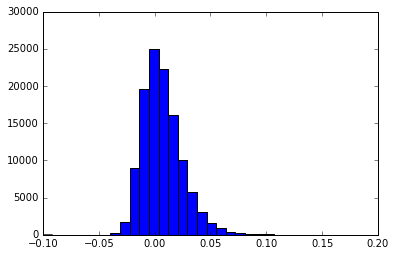

In [20]:
plt.hist(plot_total_fst, bins = [x for x in np.linspace(-0.1,0.15,30)])[2]

In [21]:
def compute_F_popTotal(series):
    return series[0]/sum(series)

In [22]:
pop_total_fst = loc.apply(compute_F_popTotal, axis = 1)
pop_total_fst.shape,pop_total_fst.head()

((116231,), NODE_1000013_length_91_cov_1.802198_37    -0.002797
 NODE_1000031_length_98_cov_2.000000_30     0.014700
 NODE_1000037_length_93_cov_2.043011_33    -0.008883
 NODE_1000042_length_93_cov_1.118280_100   -0.008273
 NODE_1000053_length_94_cov_1.744681_25    -0.020574
 dtype: float64)

<a list of 29 Patch objects>

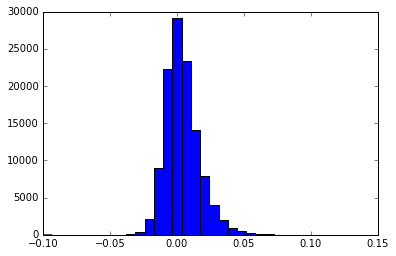

In [23]:
plt.hist(pop_total_fst, bins = [x for x in np.linspace(-0.1,0.1,30)])[2]

<a list of 29 Patch objects>

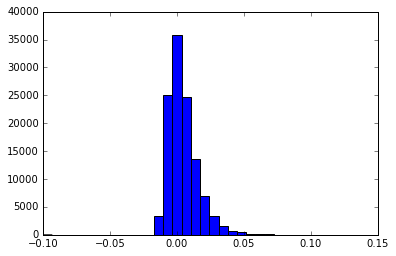

In [74]:
plt.hist(bs['Fst'].tolist(),bins =[x for x in np.linspace(-0.1,0.1,30)])[2]

In [24]:
def compute_F_plotPop(series):
    return series[1]/sum(series[1:])

In [25]:
plot_pop_fst = loc.apply(compute_F_plotPop,axis=1)
plot_pop_fst.shape,plot_pop_fst.head()

((116231,), NODE_1000013_length_91_cov_1.802198_37    -0.015723
 NODE_1000031_length_98_cov_2.000000_30    -0.007579
 NODE_1000037_length_93_cov_2.043011_33    -0.002109
 NODE_1000042_length_93_cov_1.118280_100    0.026194
 NODE_1000053_length_94_cov_1.744681_25     0.044543
 dtype: float64)

<a list of 29 Patch objects>

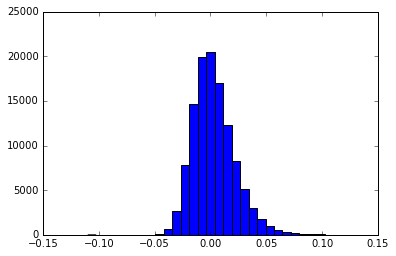

In [26]:
plt.hist(plot_pop_fst, bins = [x for x in np.linspace(-0.11,0.11,30)])[2]

In [27]:
dfs = [pop_total_fst,plot_total_fst,plot_pop_fst]
ds = ["pop_total","plot_total","plot_pop"]
for i,d in enumerate(dfs):
    d = pd.DataFrame(d)
    d.columns = [ds[i]]
    if i == 0:
        df = pd.DataFrame(d)
    else:
        df = pd.merge(df,d,left_index=True,right_index=True)
df.head()

,pop_total,plot_total,plot_pop
NODE_1000013_length_91_cov_1.802198_37,-0.002797,-0.018565,-0.015723
NODE_1000031_length_98_cov_2.000000_30,0.014700,0.007232,-0.007579
NODE_1000037_length_93_cov_2.043011_33,-0.008883,-0.011011,-0.002109
NODE_1000042_length_93_cov_1.118280_100,-0.008273,0.018138,0.026194
NODE_1000053_length_94_cov_1.744681_25,-0.020574,0.024885,0.044543


In [29]:
locDict = OrderedDict()
j = 0
for i,SNP in enumerate(hierfdf.columns[2:]):
    l = len([x for x in hierfdf.loc[:,SNP] if x > 0])
    pthere = l/len(hierfdf.index)
    locDict[SNP] = pthere
    j+=1
    if j % 1000 == 0:
        print j

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000


In [30]:
perc = pd.DataFrame()
perc[0] = locDict.values()
perc.index = locDict.keys()
perc.columns = ['perc data']
perc.head()

,perc data
NODE_1000013_length_91_cov_1.802198_37,1
NODE_1000031_length_98_cov_2.000000_30,1
NODE_1000037_length_93_cov_2.043011_33,1
NODE_1000042_length_93_cov_1.118280_100,1
NODE_1000053_length_94_cov_1.744681_25,1


In [31]:
perc.shape

(116231, 1)

In [32]:
df = pd.merge(df,perc,left_index=True,right_index=True)
df.head()

,pop_total,plot_total,plot_pop,perc data
NODE_1000013_length_91_cov_1.802198_37,-0.002797,-0.018565,-0.015723,1
NODE_1000031_length_98_cov_2.000000_30,0.014700,0.007232,-0.007579,1
NODE_1000037_length_93_cov_2.043011_33,-0.008883,-0.011011,-0.002109,1
NODE_1000042_length_93_cov_1.118280_100,-0.008273,0.018138,0.026194,1
NODE_1000053_length_94_cov_1.744681_25,-0.020574,0.024885,0.044543,1


In [33]:
filE = '/home/lindb/wbp/hierfstat/imputed/imputed_hierarchical_Fstats.txt'
df.to_csv(filE, header=True,index=True,sep="\t")

In [5]:
filE = '/home/lindb/wbp/hierfstat/imputed/imputed_hierarchical_Fstats.txt'
df = pd.read_csv(filE,header=0,index_col=0,sep='\t')
df.head()

,pop_total,plot_total,plot_pop,perc data
NODE_1000013_length_91_cov_1.802198_37,-0.002797,-0.018565,-0.015723,1.0
NODE_1000031_length_98_cov_2.000000_30,0.014700,0.007232,-0.007579,1.0
NODE_1000037_length_93_cov_2.043011_33,-0.008883,-0.011011,-0.002109,1.0
NODE_1000042_length_93_cov_1.118280_100,-0.008273,0.018138,0.026194,1.0
NODE_1000053_length_94_cov_1.744681_25,-0.020574,0.024885,0.044543,1.0


In [34]:
min(df['perc data']),max(df['perc data'])

(1.0, 1.0)

# figures

In [17]:
df.head()

,pop_total,plot_total,plot_pop,perc data
NODE_1000013_length_91_cov_1.802198_37,-0.002797,-0.018565,-0.015723,1
NODE_1000031_length_98_cov_2.000000_30,0.014700,0.007232,-0.007579,1
NODE_1000037_length_93_cov_2.043011_33,-0.008883,-0.011011,-0.002109,1
NODE_1000042_length_93_cov_1.118280_100,-0.008273,0.018138,0.026194,1
NODE_1000053_length_94_cov_1.744681_25,-0.020574,0.024885,0.044543,1


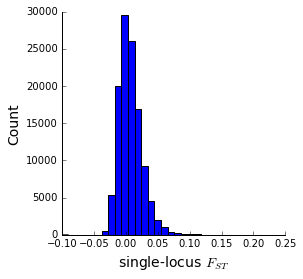

In [10]:
plt.close('all')
fig  = plt.figure(figsize=(5,5),dpi=400)
a1 = plt.subplot(111)
a1.hist(df['plot_total'],bins = [x for x in np.linspace(-0.1,0.2,30)])
a1.spines['right'].set_visible(False)
a1.spines['top'].set_visible(False)
a1.yaxis.set_ticks_position('left')
a1.xaxis.set_ticks_position('bottom')
a1.set_xlabel(r'single-locus $F_{ST}$',fontsize=14)
a1.set_ylabel('Count',fontsize=14)

fig.set_size_inches(4,4)
plt.savefig('/home/lindb/wbp/figures/multilocus_fst_distribution.pdf',format='pdf',bbox_inches='tight')

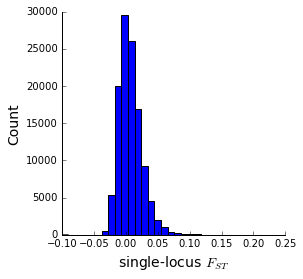

In [6]:
with PdfPages('/home/lindb/wbp/figures/multilocus_fst_distribution.pdf') as pdf:
    plt.close('all')
    fig  = plt.figure(figsize=(5,5),dpi=400)
    a1 = plt.subplot(111)
    a1.hist(df['plot_total'],bins = [x for x in np.linspace(-0.1,0.2,30)])
    a1.spines['right'].set_visible(False)
    a1.spines['top'].set_visible(False)
    a1.yaxis.set_ticks_position('left')
    a1.xaxis.set_ticks_position('bottom')
    a1.set_xlabel(r'single-locus $F_{ST}$',fontsize=14)
    a1.set_ylabel('Count',fontsize=14)
    
    fig.set_size_inches(4,4)
    pdf.savefig(fig,bbox_inches='tight')

In [7]:
?plt.savefig

In [21]:
min(df['plot_total']),max(df['plot_total'])

(-0.052821570340700001, 0.18435132508400001)

In [51]:
df['plot_total'].describe()

count    116231.000000
mean          0.006976
std           0.018286
min          -0.052822
25%          -0.005697
50%           0.004339
75%           0.016639
max           0.184351
Name: plot_total, dtype: float64

In [52]:
print 'low',0.006976-(1.96*0.018286)
print 'high',0.006976+(1.96*0.018286)

low -0.02886456
high 0.04281656


# plot abline of sig snps

### OutFLANK

In [7]:
outflank = '/home/lindb/wbp/OutFLANK/OutFLANK_snps.txt'
outdf = pd.read_csv(outflank,header=0,sep='\t')
outflanksnps = outdf['x'].tolist()
len(outflanksnps)

110

In [51]:
dd['NODE_1000013_length_91_cov_1.802198_37']

-0.018564518718000002

In [4]:
dd = OrderedDict(df['plot_total'])

In [8]:
vals = [dd[snp] for snp in outflanksnps]
len(vals)

110

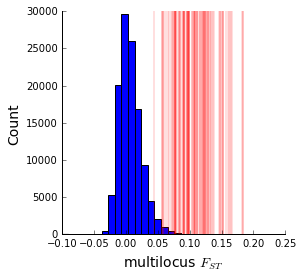

In [9]:
with PdfPages('/home/lindb/wbp/figures/multilocus_fst_distribution_outflank_overlay.pdf') as pdf:
    plt.close('all')
    fig  = plt.figure(figsize=(5,5),dpi=400)
    a1 = plt.subplot(111)
    a1.hist(df['plot_total'],bins = [x for x in np.linspace(-0.1,0.2,30)])
    a1.spines['right'].set_visible(False)
    a1.spines['top'].set_visible(False)
    a1.yaxis.set_ticks_position('left')
    a1.xaxis.set_ticks_position('bottom')
    a1.set_xlabel(r'multilocus $F_{ST}$',fontsize=14)
    a1.set_ylabel('Count',fontsize=14)
    
    [a1.axvline(x=dd[snp],c='red',linewidth=0.25,zorder=1) for snp in outflanksnps]
    #a1.axvline(x=dd[dd.keys()[0]],c='red',linewidth=0.25,zorder=1)
    
    fig.set_size_inches(4,4)
    pdf.savefig(fig,bbox_inches='tight')

### bayenv2

In [12]:
from os import listdir as ls
import os.path as op

In [13]:
#get bayenv2 snps
DIR = '/home/lindb/wbp/bayenv2/results/sigsnps'
bayfs = [op.join(DIR,f) for f in ls(DIR)]
baydict = {}
for f in bayfs:
    env = op.basename(f).split("_")[0]
    df = pd.read_csv(f,header=0,sep='\t')
    baydict[env] = df[env].tolist()
    print env,len(baydict[env])

AWS0-25 95
AWS0-50 147
Ann-ppt 49
CEC 14
Clay 22
Elev 143
GDD-Aug 157
GDD-May 80
Lat 119
Lon 67
Max-rad-input 144
Rock-cov 143
Sand 111
Silt 140
Tmax-July 50
Tmin-Jan 116
WC15Bar 86
WC3rdbar 97


In [22]:
round(0.95*116231)

110419.0

In [31]:
n5th = df['plot_total'].quantile(0.95)
n5th

0.039738934044299998

In [32]:
n99th = df['plot_total'].quantile(0.999)
n99th

0.10773465509763011

In [ ]:
/home/lindb/wbp/figures/multilocus_fst_distribution_bayenv_Ann-ppt_overlay.pdf

Tmin-Jan


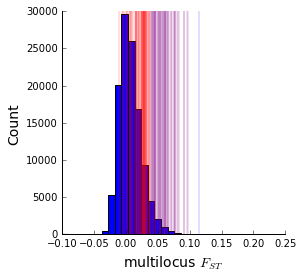

Ann-ppt


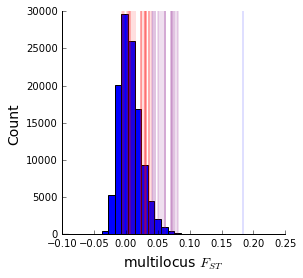

CEC


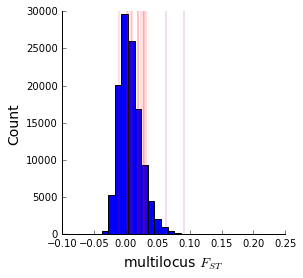

AWS0-25


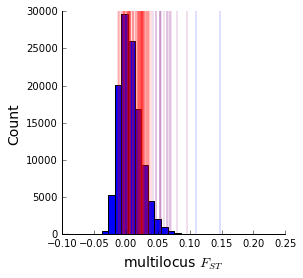

AWS0-50


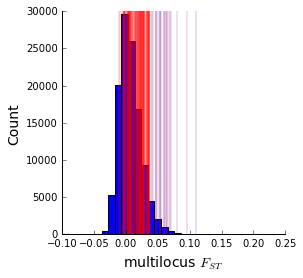

Rock-cov


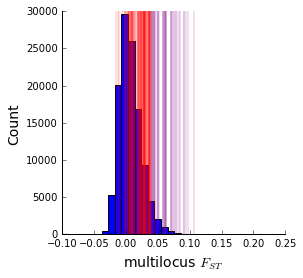

Tmax-July


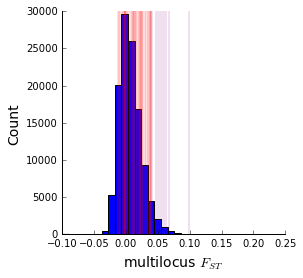

WC3rdbar


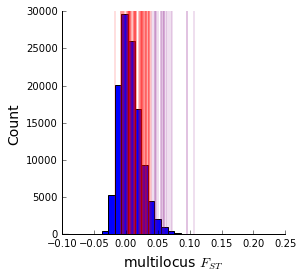

Silt


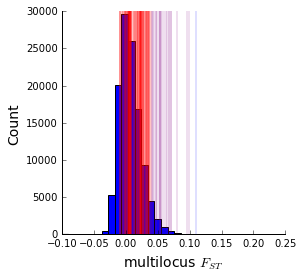

Lon


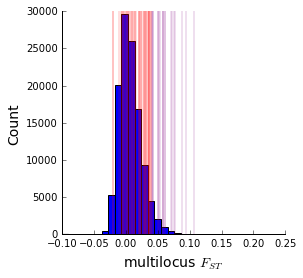

Sand


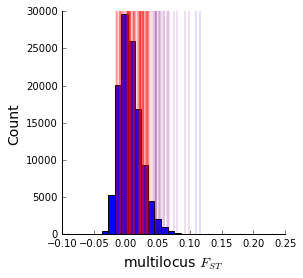

Max-rad-input


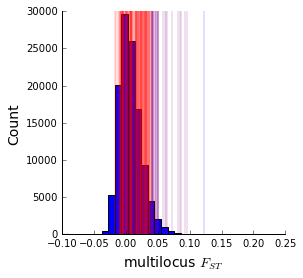

Elev


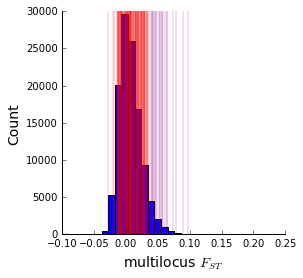

Clay


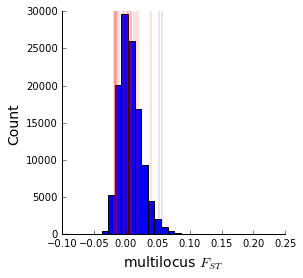

Lat


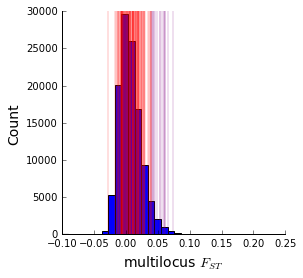

GDD-May


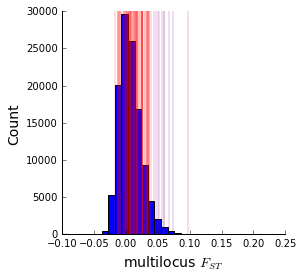

GDD-Aug


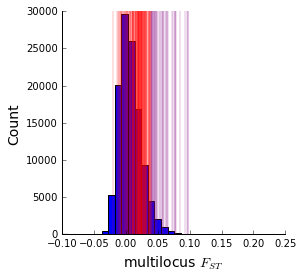

WC15Bar


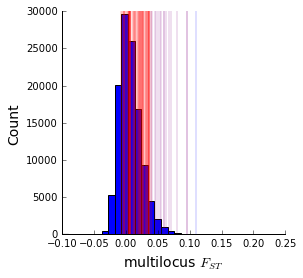

In [33]:
for env in baydict.keys():
    print env
    with PdfPages('/home/lindb/wbp/figures/multilocus_fst_distribution_bayenv_%s_overlay.pdf' % env) as pdf:
        plt.close('all')
        fig  = plt.figure(figsize=(5,5),dpi=400)
        a1 = plt.subplot(111)
        a1.hist(df['plot_total'],bins = [x for x in np.linspace(-0.1,0.2,30)])
        a1.spines['right'].set_visible(False)
        a1.spines['top'].set_visible(False)
        a1.yaxis.set_ticks_position('left')
        a1.xaxis.set_ticks_position('bottom')
        a1.set_xlabel(r'multilocus $F_{ST}$',fontsize=14)
        a1.set_ylabel('Count',fontsize=14)

        #[a1.axvline(x=dd[snp],c='red',linewidth=0.25,zorder=1) for snp in baydict[env]]
        for snp in baydict[env]:
            col = 'red'
            if dd[snp] >= n5th:
                col = 'purple'
            if dd[snp] >= n99th:
                col = 'blue'
            a1.axvline(x=dd[snp],c=col,linewidth=0.25,zorder=1)
        #a1.axvline(x=dd[dd.keys()[0]],c='red',linewidth=0.25,zorder=1)

        fig.set_size_inches(4,4)
        pdf.savefig(fig,bbox_inches='tight')
        plt.show()


In [57]:
for env in sorted(baydict):
    rcount = 0
    pcount = 0
    bcount = 0
    for snp in baydict[env]:
        if dd[snp] < n5th:
            rcount += 1
        elif dd[snp] < n99th:
            pcount += 1
        elif dd[snp] >= n99th:
            bcount += 1
    print env,rcount,pcount,bcount,rcount+pcount+bcount,len(baydict[env])

AWS0-25 78 15 2 95 95
AWS0-50 125 21 1 147 147
Ann-ppt 27 21 1 49 49
CEC 12 2 0 14 14
Clay 20 2 0 22 22
Elev 121 22 0 143 143
GDD-Aug 118 39 0 157 157
GDD-May 70 10 0 80 80
Lat 103 16 0 119 119
Lon 47 20 0 67 67
Max-rad-input 115 28 1 144 144
Rock-cov 100 43 0 143 143
Sand 88 21 2 111 111
Silt 116 23 1 140 140
Tmax-July 40 10 0 50 50
Tmin-Jan 59 56 1 116 116
WC15Bar 70 15 1 86 86
WC3rdbar 75 22 0 97 97


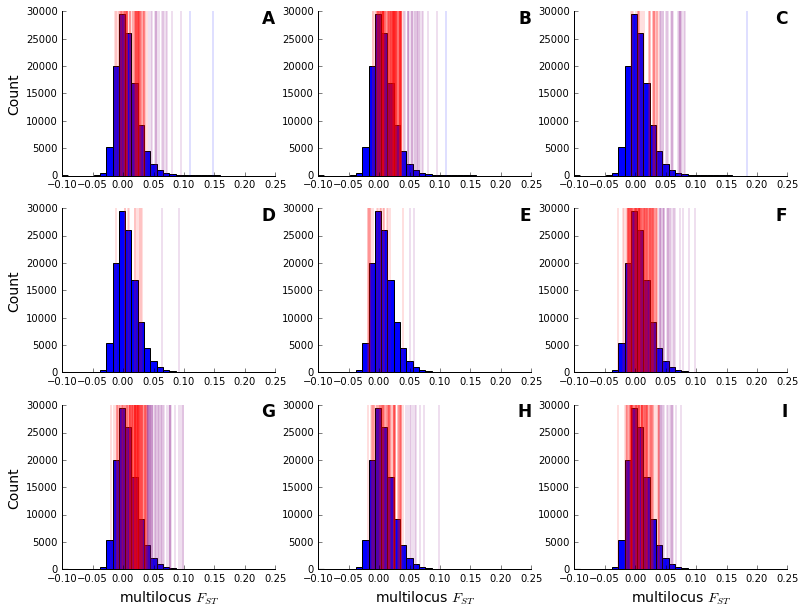

In [49]:
with PdfPages('/home/lindb/wbp/figures/multilocus_fst_distribution_bayenv_all_env_overlay.pdf') as pdf:
    
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6),(a7,a8,a9)) = plt.subplots(3, 3, figsize=(5,5),dpi=400)
    
    plotdict = {}
    count = 1
    for env in sorted(baydict.keys())[0:9]:
        plotdict[count] = plt.subplot(int("33%s" % count))

        plotdict[count].hist(df['plot_total'],bins = [x for x in np.linspace(-0.1,0.2,30)])
        plotdict[count].spines['right'].set_visible(False)
        plotdict[count].spines['top'].set_visible(False)
        plotdict[count].yaxis.set_ticks_position('left')
        plotdict[count].xaxis.set_ticks_position('bottom')
        plotdict[count].set_title(lst[count-1],y=.9,loc='right',fontsize=17,fontweight='bold')
        
        if count in [7,8,9]:
            plotdict[count].set_xlabel(r'multilocus $F_{ST}$',fontsize=14)
        if count in [1,4,7]:
            plotdict[count].set_ylabel('Count',fontsize=14)
        
        for snp in baydict[env]:
            col = 'red'
            if dd[snp] >= n5th:
                col = 'purple'
            if dd[snp] >= n99th:
                col = 'blue'
            plotdict[count].axvline(x=dd[snp],c=col,linewidth=0.25,zorder=1)
        
        fig.set_size_inches(13,10)
        pdf.savefig(fig,bbox_inches='tight')
        
        count += 1

In [52]:
sorted(baydict.keys())[9:]

['Lon',
 'Max-rad-input',
 'Rock-cov',
 'Sand',
 'Silt',
 'Tmax-July',
 'Tmin-Jan',
 'WC15Bar',
 'WC3rdbar']

In [54]:
for env in sorted(baydict):
    print env,len(baydict[env])

AWS0-25 95
AWS0-50 147
Ann-ppt 49
CEC 14
Clay 22
Elev 143
GDD-Aug 157
GDD-May 80
Lat 119
Lon 67
Max-rad-input 144
Rock-cov 143
Sand 111
Silt 140
Tmax-July 50
Tmin-Jan 116
WC15Bar 86
WC3rdbar 97


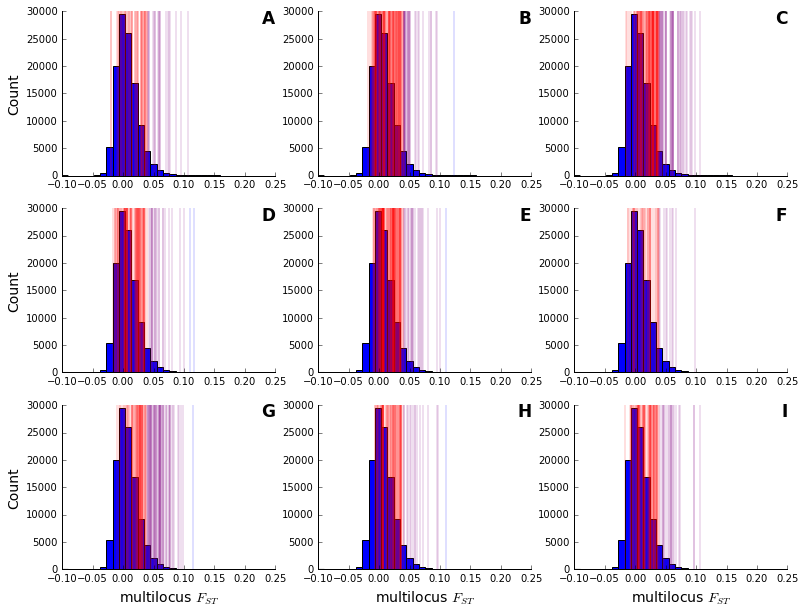

In [50]:
with PdfPages('/home/lindb/wbp/figures/multilocus_fst_distribution_bayenv_all_env_overlay_2.pdf') as pdf:
    
    plt.close('all')
    fig, ((a1,a2,a3),(a4,a5,a6),(a7,a8,a9)) = plt.subplots(3, 3, figsize=(5,5),dpi=400)
    
    plotdict = {}
    count = 1
    for env in sorted(baydict.keys())[9:]:
        plotdict[count] = plt.subplot(int("33%s" % count))

        plotdict[count].hist(df['plot_total'],bins = [x for x in np.linspace(-0.1,0.2,30)])
        plotdict[count].spines['right'].set_visible(False)
        plotdict[count].spines['top'].set_visible(False)
        plotdict[count].yaxis.set_ticks_position('left')
        plotdict[count].xaxis.set_ticks_position('bottom')
        plotdict[count].set_title(lst[count-1],y=.9,loc='right',fontsize=17,fontweight='bold')
        
        if count in [7,8,9]:
            plotdict[count].set_xlabel(r'multilocus $F_{ST}$',fontsize=14)
        if count in [1,4,7]:
            plotdict[count].set_ylabel('Count',fontsize=14)
        
        for snp in baydict[env]:
            col = 'red'
            if dd[snp] >= n5th:
                col = 'purple'
            if dd[snp] >= n99th:
                col = 'blue'
            plotdict[count].axvline(x=dd[snp],c=col,linewidth=0.25,zorder=1)
        
        fig.set_size_inches(13,10)
        pdf.savefig(fig,bbox_inches='tight')
        
        count += 1